# Testing Tabular SR

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from functools import partial
from IPython.display import clear_output

%matplotlib inline

In [3]:
MOVE_DIRECTIONS = {
    # (i, j)-based coordinates [or (y, x) for the viewer]
    'right': (0, 1), 'down': (1, 0), 'left': (0, -1), 'up': (-1, 0)
}
DIRECTIONS_ORDER = ['right', 'down', 'left', 'up']
TURN_DIRECTIONS = {'right': 1, 'left': -1}


class MoveDynamics:
    @staticmethod
    def try_move(
            position: tuple[int, int], move_direction: tuple[int, int],
            shape: tuple[int, int], obstacle_mask: np.ndarray
    ):
        """
        Performs the move if it's allowed.
        Returns new position and flag whether or not the move was successful.
        """
        new_position = MoveDynamics.move(position, move_direction)
        new_position = MoveDynamics.clip2d(new_position, shape)

        success = MoveDynamics.is_move_successful(position, new_position, obstacle_mask)
        if not success:
            new_position = position
        return new_position, success

    @staticmethod
    def is_move_successful(
            position: tuple[int, int], new_position: tuple[int, int],
            obstacle_mask: np.ndarray
    ):
        """Checks whether move is happened and is allowed."""
        # changed position but not stepped into the wall
        return new_position != position and not obstacle_mask[new_position]

    @staticmethod
    def move(position: tuple[int, int], direction: tuple[int, int]):
        """
        Calculates new position for the move to the specified direction
        without checking whether this move is allowed or not.
        """
        i, j = position
        i += direction[0]
        j += direction[1]
        return i, j

    @staticmethod
    def clip2d(position: tuple[int, int], shape: tuple[int, int]):
        """Clip position to be inside specified rectangle."""
        def clip(x, high):
            if x >= high:
                return high - 1
            if x < 0:
                return 0
            return x
        i, j = position
        i = clip(i, shape[0])
        j = clip(j, shape[1])
        return i, j


In [4]:
def get_four_rooms_obstacles():
    four_rooms_obstacles = """
-------x--------
-------x--------
-------x--------
----------------
-------x--------
-------x--------
-------x--------
-------x--------
xxx-xxxxxxxxx-xx
--------x-------
--------x-------
--------x-------
--------x-------
--------x-------
----------------
--------x-------
--------x-------
"""
    return np.array([
        [int(c == 'x') for c in row]
        for row in four_rooms_obstacles.strip().split('\n')
    ])


four_rooms_obstacles = get_four_rooms_obstacles()
print(four_rooms_obstacles.shape)
four_rooms_obstacles

(17, 16)


array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
def get_clean_room_obstacles(size):
    return np.zeros((size, size), dtype=int)

get_clean_room_obstacles(8)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [6]:
from numpy.random import Generator

TPos = tuple[int, int]
TSize2d = tuple[int, int]

class GridWorld:
    size: TSize2d
    init_agent_pos: TPos
    obstacles: np.ndarray
    
    agent_pos: TPos
    
    terminal: TPos
    reward: float
    const_punish: float
    terminal_decay: float
    time_limit: int | None

    observation_type: str
    pixel_size: int
    color_map: dict
    
    _pos: TPos
    _obs: np.ndarray
    _step: int
    _terminated: bool
    _next_pos_cache: dict[tuple[TPos, int], TPos]
    
    def __init__(
        self,
        *,
        size: TSize2d, 
        agent: TPos = None,
        obstacle_mask: np.ndarray = None,
        terminal: TPos = None,
        reward: float = None,
        const_punish: float = 0.,
        terminal_decay: float = 1.0,
        time_limit: int = None,
        pixel_size: int = 1,
        color_map: dict = None,
        observation_type: str = 'state'
    ):
        self.size = size
        self.init_agent_pos = agent
        
        self.action_space = gym.spaces.Discrete(4)
        self.observation_type = observation_type
        if self.observation_type == 'img':
            self.observation_space = gym.spaces.Box(0., 1., shape=self.size, dtype=np.float)
        elif self.observation_type == 'state':
            self.observation_space = gym.spaces.Discrete(np.prod(self.size))
        elif self.observation_type == 'pos':
            self.observation_space = gym.spaces.Box(
                low=np.array([0, 0], dtype=np.int),
                high=np.array(self.size, dtype=np.int) - 1,
                shape=(2,), dtype=np.int
            )
        else:
            raise ValueError(f'Observation type {self.observation_type} is not supported')
        
        self.obstacles = np.zeros(self.size, dtype=int)
        if obstacle_mask is not None:
            self.obstacles[:] = obstacle_mask

        self.terminal = terminal
        self.reward = reward
        assert const_punish >= 0., 'I expect negative punish'
        self.const_punish = const_punish
        assert terminal_decay <= 1., 'I expect terminal reward decaying, i.e. terminal_decay <= 1.0'
        self.terminal_decay = terminal_decay
        
        self.time_limit = time_limit
        
        self.pixel_size = pixel_size
        self.color_map = color_map

        self._pos = self.init_agent_pos
        self._obs = self._get_initial_observation()
        self._next_pos_cache = {}
        self.reset()
    
    def reset(self, seed=None):
        self.action_space = gym.spaces.Discrete(4, seed=seed)
        self._rng = np.random.default_rng(seed)

        # do not forget to update observation
        #   1) regularly: old pos -> floor; init pos -> agent
        self._update_observation(self._pos, self.init_agent_pos)
        #   2) restore target if it was overwritten: terminal -> target
        self._fill(self.terminal, self.color_map['target'])

        self._pos = self.init_agent_pos
        self._step = 0
        self._terminated = self._is_current_pos_terminal()

        img, pos, state = self._obs, self._pos, self.to_state(self._pos)
        info = dict(img=img, pos=pos, state=state)
        return info[self.observation_type], info
    
    def step(self, action):
        assert not self._terminated

        self._step += 1
        self._pos = self._move(action)

        # move before getting the reward
        reward = self._get_reward()
        
        # update terminated state after getting the reward
        terminated = self._is_current_pos_terminal()
        truncated = self.time_limit is not None and self._step >= self.time_limit
        self._terminated = terminated or truncated

        img, pos, state = self._obs, self._pos, self.to_state(self._pos)
        info = dict(img=img, pos=pos, state=state)
        
        return info[self.observation_type], reward, terminated, truncated, info

    def to_state(self, pos: TPos):
        return pos[0] * self.size[1] + pos[1]

    def render(self):
        return self._obs
    
    def render_rgb(self):
        plt.imshow(self._obs)
        
    def _is_current_pos_terminal(self) -> bool:
        return self._pos == self.terminal
    
    def _get_reward(self) -> float:
        reward = 0
        if self._pos == self.terminal and not self._terminated:
            reward += self.terminal_decay ** self._step
        reward -= self.const_punish
        return reward
    
    def _move(self, action) -> TPos:
        new_pos = self._next_pos_cache.get((self._pos, action), None)
        if new_pos is None:
            # call true dynamics to get new position
            new_pos, _ = MoveDynamics.try_move(
                position=self._pos,
                move_direction=MOVE_DIRECTIONS[DIRECTIONS_ORDER[action]],
                shape=self.size, obstacle_mask=self.obstacles
            )
            self._next_pos_cache[(self._pos, action)] = new_pos
        
        # update observation after move
        self._update_observation(self._pos, new_pos)
        return new_pos
    
    def _get_initial_observation(self) -> np.ndarray:
        # make observation map with pixel positions
        obs = np.zeros(self.size)
        obs[self.obstacles == 0] = self.color_map['floor']
        obs[self.obstacles == 1] = self.color_map['obstacle']
        obs[self.terminal] = self.color_map['target']
        obs[self._pos] = self.color_map['agent']
        
        # then resize observation transforming each pixel to the square
        px = self.pixel_size
        return np.repeat(np.repeat(obs, px, axis=0), px, axis=1)
        
    
    def _update_observation(self, pos, new_pos):
        # fill old pos with floor color, fill new pos with agent color
        px = self.pixel_size
        floor, agent = self.color_map['floor'], self.color_map['agent']
        
        self._fill(pos, floor)
        self._fill(new_pos, agent)
            
    def _fill(self, pos, color):
        # fill position with the color
        (i, j), px = pos, self.pixel_size
        i, j = i*px, j*px
        self._obs[i:i+px, j:j+px] = color

In [7]:
def make_env(
    observation_type: str, # 'img' / 'state' / 'pos'
    obstacle_mask, agent, terminal,
    const_punish=0., terminal_decay=0.99, time_limit=50, pixel_size=2
):
    return GridWorld(
        size=obstacle_mask.shape, 
        obstacle_mask=obstacle_mask,
        agent=agent, terminal=terminal,
        const_punish=const_punish, terminal_decay=terminal_decay,
        time_limit=time_limit,
        pixel_size=pixel_size, color_map=dict(floor=.3, obstacle=.02, agent=.6, target=.9),
        observation_type=observation_type
    )

def make_four_rooms(**kwargs):
    four_rooms_obstacles = get_four_rooms_obstacles()  
    return make_env(obstacle_mask=four_rooms_obstacles, **kwargs)

def make_clean_room(size, **kwargs):
    clean_room_obstacles = get_clean_room_obstacles(size)
    return make_env(obstacle_mask=clean_room_obstacles, **kwargs)

(34, 0.0, False, False, {'img': array([[0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
       ...,
       [0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, ..., 0.3, 0.9, 0.9],
       [0.3, 0.3, 0.3, ..., 0.3, 0.9, 0.9]]), 'pos': (2, 2), 'state': 34})


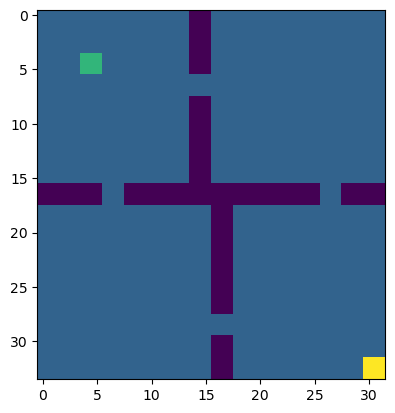

In [8]:
env = make_four_rooms(
    agent=(0, 0), terminal=(16,15), 
    const_punish=0., terminal_decay=0.99,
    time_limit=50, pixel_size=2,
    observation_type='state'
)
env.reset()
env.step(1)
env.step(0)
env.step(1)
print(env.step(0))
env.render_rgb()

(18, 0.0, False, False, {'img': array([[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.6, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.6, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3]

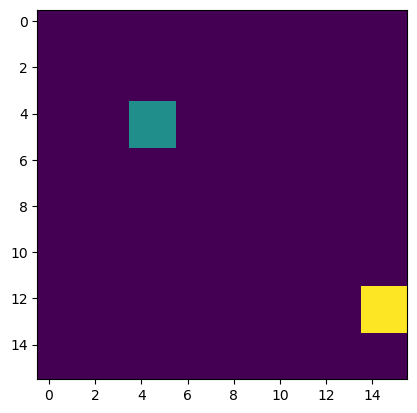

In [9]:
env = make_clean_room(
    size=8,
    agent=(0, 0), terminal=(6,7), 
    const_punish=0., terminal_decay=0.99,
    time_limit=50, pixel_size=2,
    observation_type='state'
)
env.reset()
env.step(1)
env.step(0)
env.step(1)
print(env.step(0))
env.render_rgb()

In [10]:
def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

In [41]:
rooms = np.array([
    [[0, 8], [0, 7]],
    [[0, 8], [8, 16]],
    [[9, 17], [0, 8]],
    [[9, 17], [9, 16]]
])
def sample_point_in_room(n, rng=None):
    if rng is None or isinstance(rng, (int, np.int64)):
        rng = np.random.default_rng(rng)
    room = rooms[n]
    return rng.integers(*room[0]), rng.integers(*room[1])

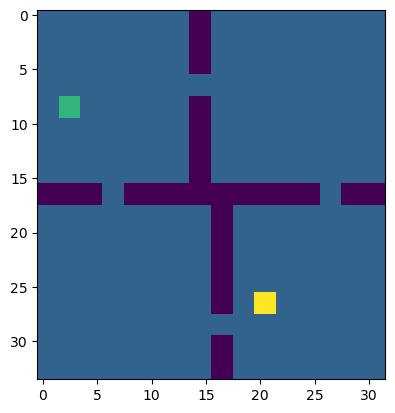

In [12]:
# env = gym.make("Taxi-v3", render_mode="rgb_array")
env = make_four_rooms(
    # size=8,
    agent=sample_point_in_room(0, 12),
    terminal=sample_point_in_room(3, 12), 
    const_punish=0., terminal_decay=0.99,
    time_limit=50, pixel_size=2,
    observation_type='state'
)
env.reset(seed=13)
plt.imshow(env.render())

## Q-learning

In [13]:
class DecayVal:
    val: float
    decay: float
    schedule: int
    def __init__(self, val, decay, schedule):
        self.val = val
        self.decay = decay
        self.i = 0
        self.schedule = schedule

    def __call__(self):
        return self.val

    def step(self):
        self.i += 1
        if self.i % self.schedule == 0:
            self.val *= self.decay

    def copy(self):
        return DecayVal(self.val, self.decay, self.schedule)


class QAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)

    def reset(self):
        self.eps.step()
        self.lr.step()
        
    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps():
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, done):
        # реализуйте шаг Q-обучения
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        Q_s_a = self.Q[s, a]
        V_sn = np.max(self.Q[s_n])

        td_error = r + self.gamma * (1-done) * V_sn - Q_s_a
        self.Q[s, a] += self.lr() * td_error

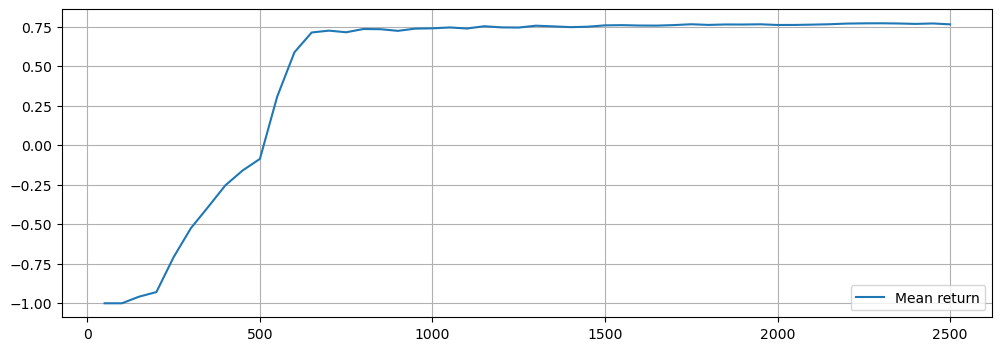

Episode: 2500, Return: 0.7801888648295346, AvgReturn[50]: 1


(0.04669747052543716, 0.03221225472000002)

In [14]:
from functools import partial

def train(env, agent, n_episodes, seed, show_progress_schedule=50, starting_episode=1):
    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(starting_episode, starting_episode + n_episodes):
        state, _ = env.reset(seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)

            # выполняем действие в среде
            next_state, reward, terminated, truncated, info = env.step(action)
            # шаг обучения
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            episode_return += reward
            done = terminated or truncated
            if done:
                agent.reset()
                break

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []
            
            show_progress(avg_returns)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )

    return avg_returns

env = make_four_rooms(
    # size=16,
    agent=sample_point_in_room(0, 12),
    terminal=sample_point_in_room(3, 12),  
    const_punish=0.01, terminal_decay=0.999,
    time_limit=100, pixel_size=2,
    observation_type='state'
)
seed = 1337
agent = QAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
)

log_q = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

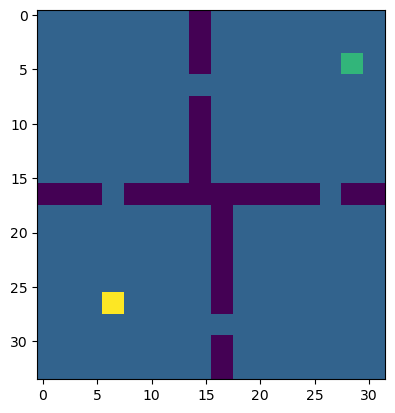

In [89]:
rng = np.random.default_rng()
seeds = [[11, 14, 15, 19, 21], [11, 14, 19, 21], [11, 14, 19, 21], [11, 14, 19, 21]]
tasks = [[0, 3], [0, 2], [2, 1], [3, 0], [1, 2]]
task = 4
room_agent, room_term = tasks[task]
seed_agent, seed_term = rng.choice(seeds[room_agent]), rng.choice(seeds[room_term])
env = make_four_rooms(
    agent=sample_point_in_room(room_agent, seed_agent),
    terminal=sample_point_in_room(room_term, seed_term),
    const_punish=0.01, terminal_decay=0.999,
    time_limit=100, pixel_size=2,
    observation_type='state'
)
env.render_rgb()

### Q-learning sequential goal change

In [94]:
def run_multitask_experiment(env, f_agent, seed=1337):
    rng = np.random.default_rng(seed)
    seeds = [[11, 14, 15, 19, 21], [11, 14, 19, 21], [11, 14, 19, 21], [11, 14, 19, 21]]
    tasks = [[0, 3], [0, 2], [2, 1], [3, 0], [1, 2]]
        
    log_returns = []
    
    lr = DecayVal(val=0.1, decay=0.97, schedule=100)
    eps = DecayVal(val=0.1, decay=0.97, schedule=100)
    
    agent = f_agent(
        env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
        lr=lr.copy(),
        eps=eps.copy(),
    )
    for task in range(10):
        room_agent, room_term = tasks[task % len(tasks)]
        seed_agent, seed_term = rng.choice(seeds[room_agent]), rng.choice(seeds[room_term])
        env = make_four_rooms(
            agent=sample_point_in_room(room_agent, seed_agent),
            terminal=sample_point_in_room(room_term, seed_term),
            const_punish=0.01, terminal_decay=0.999,
            time_limit=100, pixel_size=2,
            observation_type='state'
        )
        agent.lr = lr.copy()
        agent.eps = eps.copy()
        total_episodes = 0 if not log_returns else log_returns[-1][0]
        
        log_returns.extend(
            train(
                env, agent, n_episodes=1000, seed=seed, 
                show_progress_schedule=50, starting_episode=total_episodes + 1
            )
        )
    return log_returns

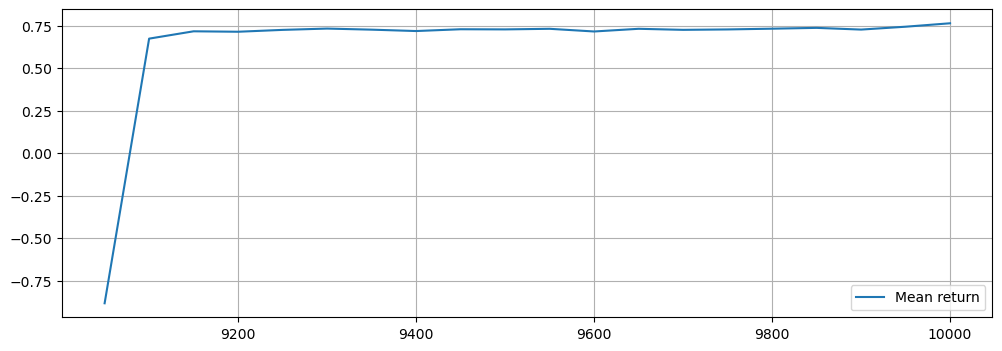

Episode: 10000, Return: 0.7582294672887403, AvgReturn[50]: 1


(0.04669747052543716, 0.03221225472000002)

In [95]:
log_q = run_multitask_experiment(env, QAgent)
agent.lr(), agent.eps()

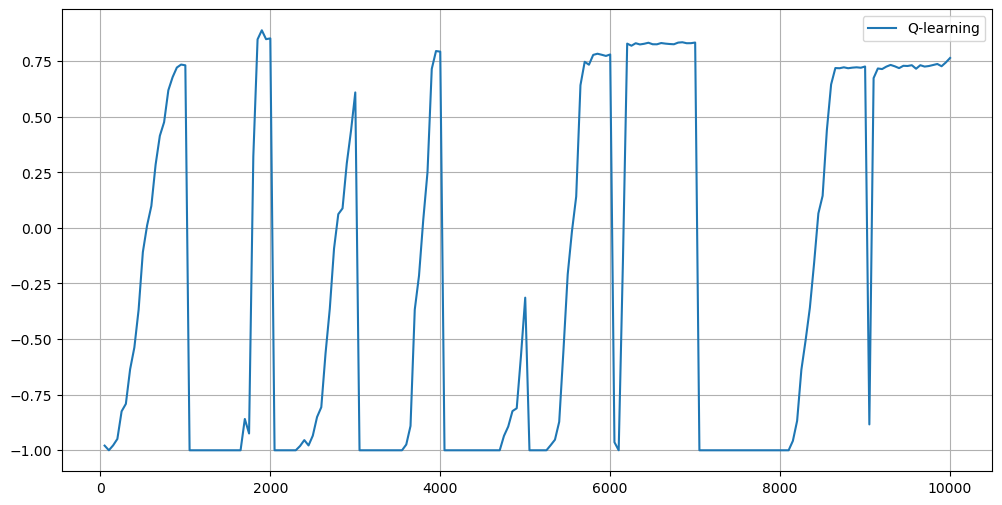

In [96]:
compare_logs([
    (log_q, 'Q-learning'),
    # (log_q_sr, 'Q-SR'),
    # (log_sarsa_sr, 'Dyna-Q imperfect model'),
])

## SR

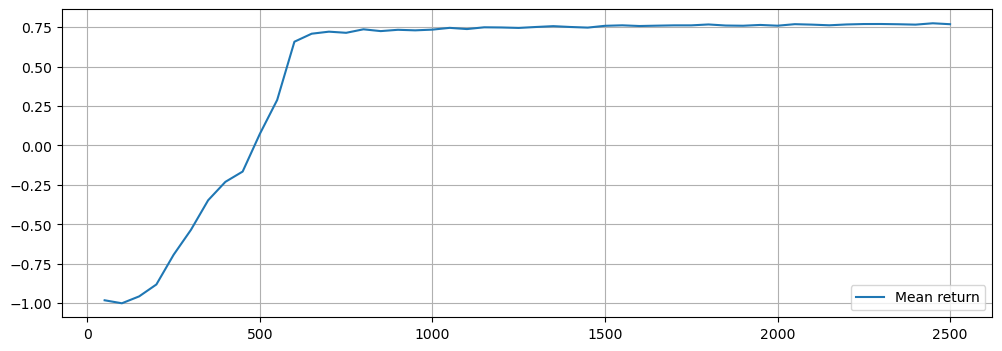

Episode: 2500, Return: 0.7801888648295346, AvgReturn[50]: 1


(0.04669747052543716, 0.03221225472000002)

In [92]:
class SrAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, seed, sarsa=False):
        self.r = np.zeros((n_states,))
        self.M = np.zeros((n_states, n_actions, n_states))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self.sarsa = sarsa
        self._rng = np.random.default_rng(seed)

    def reset(self):
        self.eps.step()
        self.lr.step()

    def Q(self, s):
        return np.dot(self.M[s], self.r)
        
    def act(self, s, greedy=False):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if not greedy and self._rng.random() < self.eps():
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q(s))  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, done):
        # реализуйте шаг Q-обучения
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        self.r[s_n] += self.lr() * (r - self.r[s_n])

        # do I need max(M)?
        a_n = self.act(s_n, greedy=not self.sarsa)

        target = self.gamma * (1 - done) * self.M[s_n, a_n]
        target[s_n] += 1.
        
        td_error = target - self.M[s,a]
        self.M[s, a] += self.lr() * td_error

env = make_four_rooms(
    # size=16,
    agent=sample_point_in_room(0, 12),
    terminal=sample_point_in_room(3, 12),  
    const_punish=0.01, terminal_decay=0.999,
    time_limit=100, pixel_size=2,
    observation_type='state'
)
seed = 1337
agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
    sarsa=False
)

log_q_sr = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

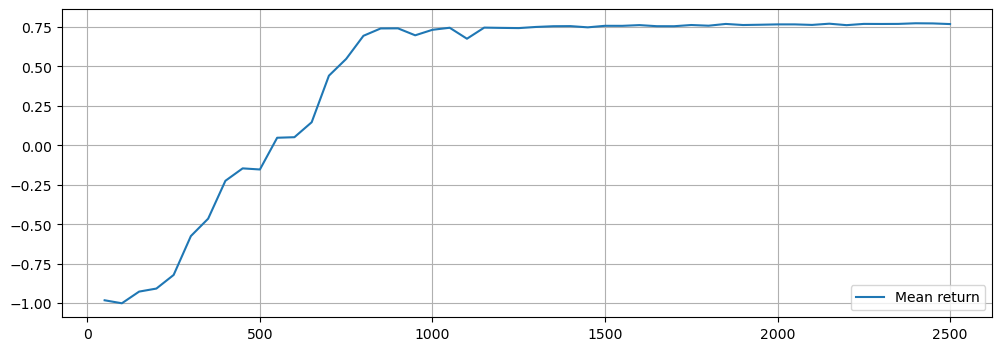

Episode: 2500, Return: 0.7582294672887403, AvgReturn[50]: 1


(0.04669747052543716, 0.03221225472000002)

In [143]:
env = make_four_rooms(
    # size=16,
    agent=sample_point_in_room(0, 12),
    terminal=sample_point_in_room(3, 12),  
    const_punish=0.01, terminal_decay=0.999,
    time_limit=100, pixel_size=2,
    observation_type='state'
)
seed = 1337
agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
    sarsa=True
)

log_sarsa_sr = train(env, agent, n_episodes=2500, seed=seed, show_progress_schedule=50)
agent.lr(), agent.eps()

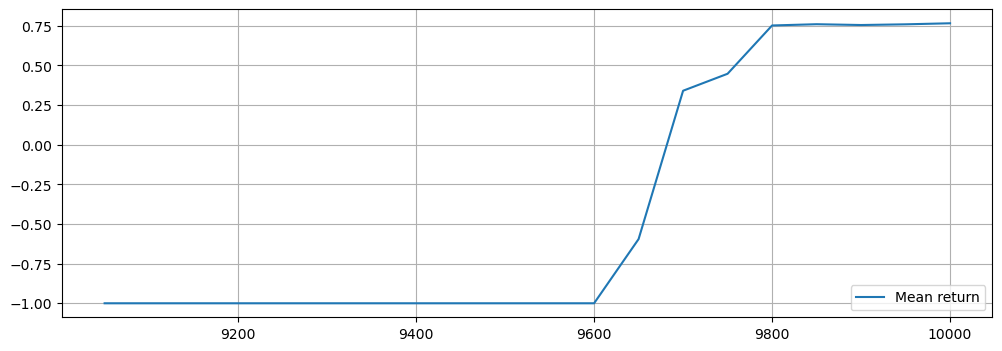

Episode: 10000, Return: 0.7801888648295346, AvgReturn[50]: 1


(0.04669747052543716, 0.03221225472000002)

In [97]:
log_q_sr = run_multitask_experiment(env, partial(SrAgent, sarsa=False))
agent.lr(), agent.eps()

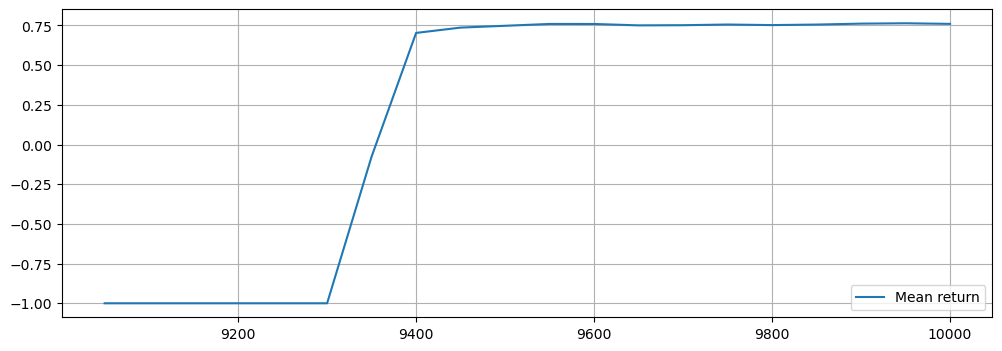

Episode: 10000, Return: 0.7692086759647051, AvgReturn[50]: 1


(0.04669747052543716, 0.03221225472000002)

In [99]:
log_sarsa_sr = run_multitask_experiment(env, partial(SrAgent, sarsa=True))
agent.lr(), agent.eps()

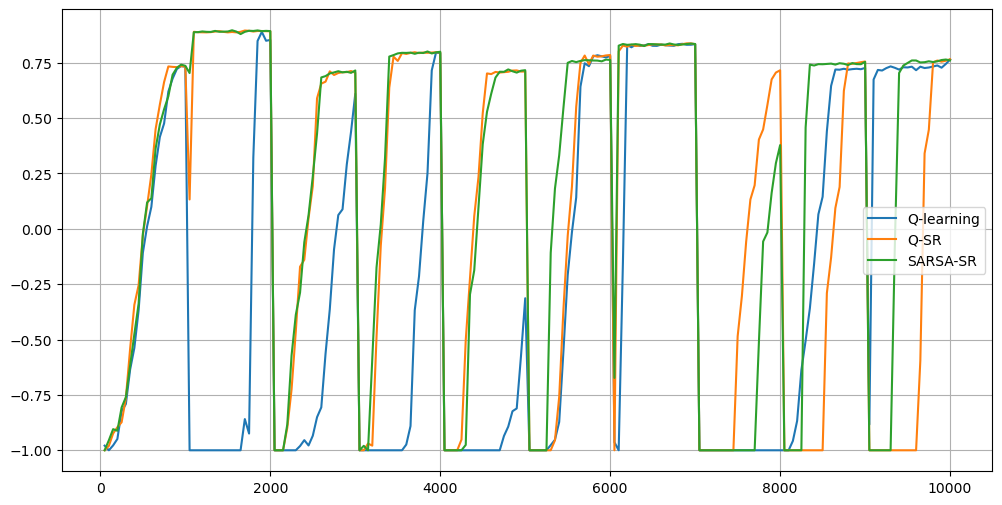

In [100]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_q_sr, 'Q-SR'),
    (log_sarsa_sr, 'SARSA-SR'),
])

### SR analysis

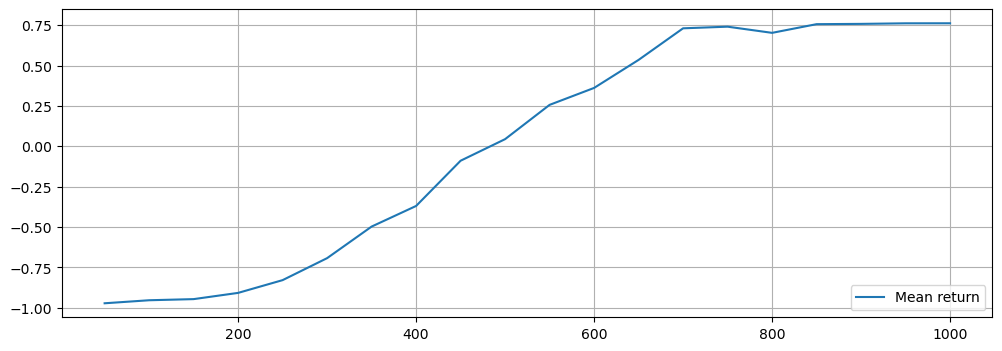

Episode: 1000, Return: 0.7801888648295346, AvgReturn[50]: 1


[(50, -0.9722897471299524),
 (100, -0.9535465181423837),
 (150, -0.9465442585115226),
 (200, -0.9079579908341294),
 (250, -0.8289728682766266),
 (300, -0.6928432683938781),
 (350, -0.49735170669922285),
 (400, -0.36966471931889217),
 (450, -0.08957778061763425),
 (500, 0.044032381514641526),
 (550, 0.25631533399897344),
 (600, 0.3612167409310434),
 (650, 0.5347848660789591),
 (700, 0.7303653873355477),
 (750, 0.7404739850858132),
 (800, 0.7022425788413648),
 (850, 0.7560387339454288),
 (900, 0.7577922169191257),
 (950, 0.7613056223308807),
 (1000, 0.7615250110152775)]

In [103]:
def run_singletask_analysis(env, f_agent, seed=1337):
    rng = np.random.default_rng(seed)
    seeds = [[11, 14, 15, 19, 21], [11, 14, 19, 21], [11, 14, 19, 21], [11, 14, 19, 21]]
    tasks = [[0, 3], [0, 2], [2, 1], [3, 0], [1, 2]]
        
    log_returns = []
    
    lr = DecayVal(val=0.1, decay=0.97, schedule=100)
    eps = DecayVal(val=0.1, decay=0.97, schedule=100)
    
    agent = f_agent(
        env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
        lr=lr.copy(),
        eps=eps.copy(),
    )

    room_agent, room_term = rng.choice(tasks)
    seed_agent, seed_term = rng.choice(seeds[room_agent]), rng.choice(seeds[room_term])
    env = make_four_rooms(
        agent=sample_point_in_room(room_agent, seed_agent),
        terminal=sample_point_in_room(room_term, seed_term),
        const_punish=0.01, terminal_decay=0.999,
        time_limit=100, pixel_size=2,
        observation_type='state'
    )
    agent.lr = lr.copy()
    agent.eps = eps.copy()
    total_episodes = 0 if not log_returns else log_returns[-1][0]
    
    log_returns.extend(
        train(
            env, agent, n_episodes=1000, seed=seed, 
            show_progress_schedule=50, starting_episode=total_episodes + 1
        )
    )
    return log_returns

run_singletask_analysis(env, partial(SrAgent, sarsa=True))

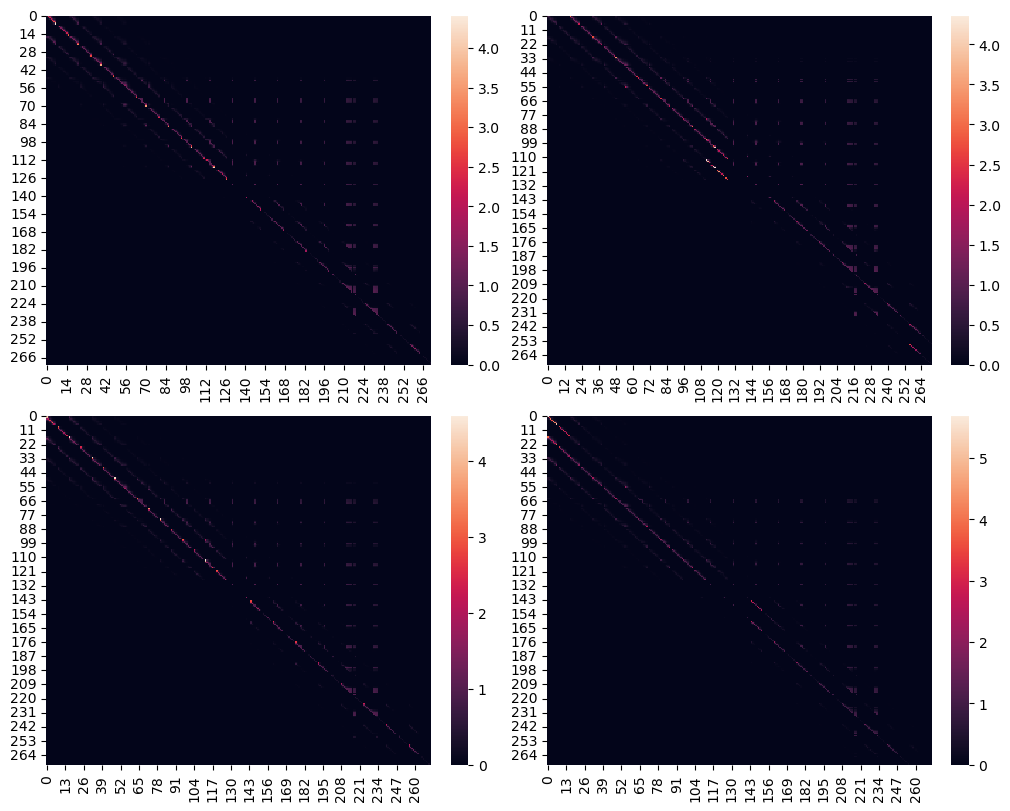

In [124]:
R, M = agent.r, agent.M

n_actions = env.action_space.n
fig, axes = plt.subplots(2, n_actions//2, layout='constrained', figsize=(10, 8))

axes = np.array(axes).flatten()
for i in range(n_actions):
    ax = axes[i]
    sns.heatmap(M[:, i, :], ax=ax)

In [128]:
from pathlib import Path
from typing import Union, Optional, Any, List

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
from matplotlib.image import AxesImage
from numpy import ma



def ensure_list(arr: Optional[Union[Any, List[Any]]]) -> Optional[List[Any]]:
    """Wraps single value to list or return list as it is."""
    if arr is not None and not isinstance(arr, list):
        arr = [arr]
    return arr


def safe_ith(arr: Optional[List], ind: int, default: Any = None) -> Optional[Any]:
    """Performs safe index access. If array is None, returns default."""
    if arr is not None:
        return arr[ind]
    return default


def plot_grid_images(
        images: Union[np.ndarray, List[np.ndarray]],
        titles: Union[str, List[str]] = None,
        show: bool = True,
        save_path: Optional[Path] = None,
        with_value_text_flags: List[bool] = None,
        cols_per_row: int = 5
):
    images = ensure_list(images)
    titles = ensure_list(titles)
    n_images = len(images)

    n_rows = (n_images - 1) // cols_per_row + 1
    n_cols = min(n_images, cols_per_row)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(5 * n_cols, 5 * n_rows)
    )
    if n_images == 1:
        axes = [axes]

    for i in range(n_images):
        ax = axes[i] if n_images <= cols_per_row else axes[i//cols_per_row][i%cols_per_row]
        img = images[i]
        title = safe_ith(titles, i)
        with_value_text = safe_ith(with_value_text_flags, i)
        _plot_grid_image(ax, img, title=title, with_value_text=with_value_text)

    fig.tight_layout()

    if show:
        plt.show()

    if save_path is not None:
        fig.savefig(save_path, dpi=120)
        plt.close('all')


def _plot_grid_image(
        ax, data: np.ndarray, title: Optional[str] = None,
        with_value_text: bool = False
):
    if title is not None:
        ax.set_title(title)
    ax.xaxis.tick_top()

    if data.ndim == 3 and data.shape[2] == 4:
        plot_triangled(ax, data)
        return
    if data.ndim == 1:
        plot_regular_plot(ax, data)
        return

    h, w = data.shape[:2]
    # labels: major
    ax.set_xticks(np.arange(w + 1))
    ax.set_yticks(np.arange(h + 1))
    ax.set_xticklabels(np.arange(w+1))
    ax.set_yticklabels(np.arange(h+1))
    # grid: minor
    ax.set_xticks(np.arange(w + 1) - .5, minor=True)
    ax.set_yticks(np.arange(h + 1) - .5, minor=True)
    ax.grid(which="minor", color='grey', linestyle='-', linewidth=.5)

    threshold = .03 if data.dtype == float else 2
    im = ax.imshow(
        data,
        norm=mpl.colors.SymLogNorm(linthresh=threshold, base=10)
    )
    if with_value_text:
        valfmt = '{x:.1f}' if data.dtype == float else '{x}'
        annotate_heatmap(im, data=data, valfmt=valfmt)


def plot_regular_plot(ax, data: np.ndarray):
    ax.plot(np.arange(data.size), data)


def plot_triangled(ax, data: np.ndarray):
    h, w = data.shape[:2]
    x = np.linspace(0, w, 2 * w + 1) - .5
    y = np.linspace(0, h, 2 * h + 1) - .5
    # noinspection PyTypeChecker
    points: tuple[np.ndarray, np.ndarray] = np.meshgrid(x, y)
    pxs, pys = points[0].ravel(), points[1].ravel()

    x_data, y_data = [], []
    for y_shit in range(h):
        for x_shift in range(w):
            up_x = 0, 1, 2
            up_y = 0, 1, 0

            down_x = 0, 1, 2
            down_y = 2, 1, 2

            left_x = 0, 1, 0
            left_y = 0, 1, 2

            right_x = 2, 1, 2
            right_y = 0, 1, 2

            assert DIRECTIONS_ORDER[0] == 'right'
            ixs = np.vstack((right_x, down_x, left_x, up_x)) + 2 * x_shift
            iys = np.vstack((right_y, down_y, left_y, up_y)) + 2 * y_shit
            x_data.append(ixs)
            y_data.append(iys)

    ixs = np.vstack(x_data)
    iys = np.vstack(y_data)
    ips = np.ravel_multi_index([iys, ixs], dims=points[0].shape)

    # labels: major
    ax.set_xticks(np.arange(w + 1))
    ax.set_yticks(np.arange(h + 1))
    ax.set_xticklabels(np.arange(w+1))
    ax.set_yticklabels(np.arange(h+1))
    # ax.grid(color='grey', linestyle='-', linewidth=2.)
    # grid: minor
    ax.set_xticks(np.arange(w + 1) - .5, minor=True)
    ax.set_yticks(np.arange(h + 1) - .5, minor=True)
    ax.grid(which="minor", color='grey', linestyle='-', linewidth=.5)
    ax.margins(x=0, y=0)
    ax.tripcolor(pxs, pys, ips, data.ravel())
    ax.invert_yaxis()


def annotate_heatmap(
        im: AxesImage, data: np.ndarray = None, valfmt="{x:.2f}",
        textcolors=("white", "black"), threshold=None, **textkw
):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if isinstance(data, ma.MaskedArray) and data.mask[i, j]:
                continue
            over_threshold = im.norm(data[i, j]) > threshold
            kw.update(color=textcolors[int(over_threshold)])
            im.axes.text(j, i, valfmt(data[i, j], None), **kw)

In [130]:
Q = np.dot(M, R)
Q.shape

R_sq, Q_sq = R.reshape(env.size), Q.reshape(env.size + (-1,))

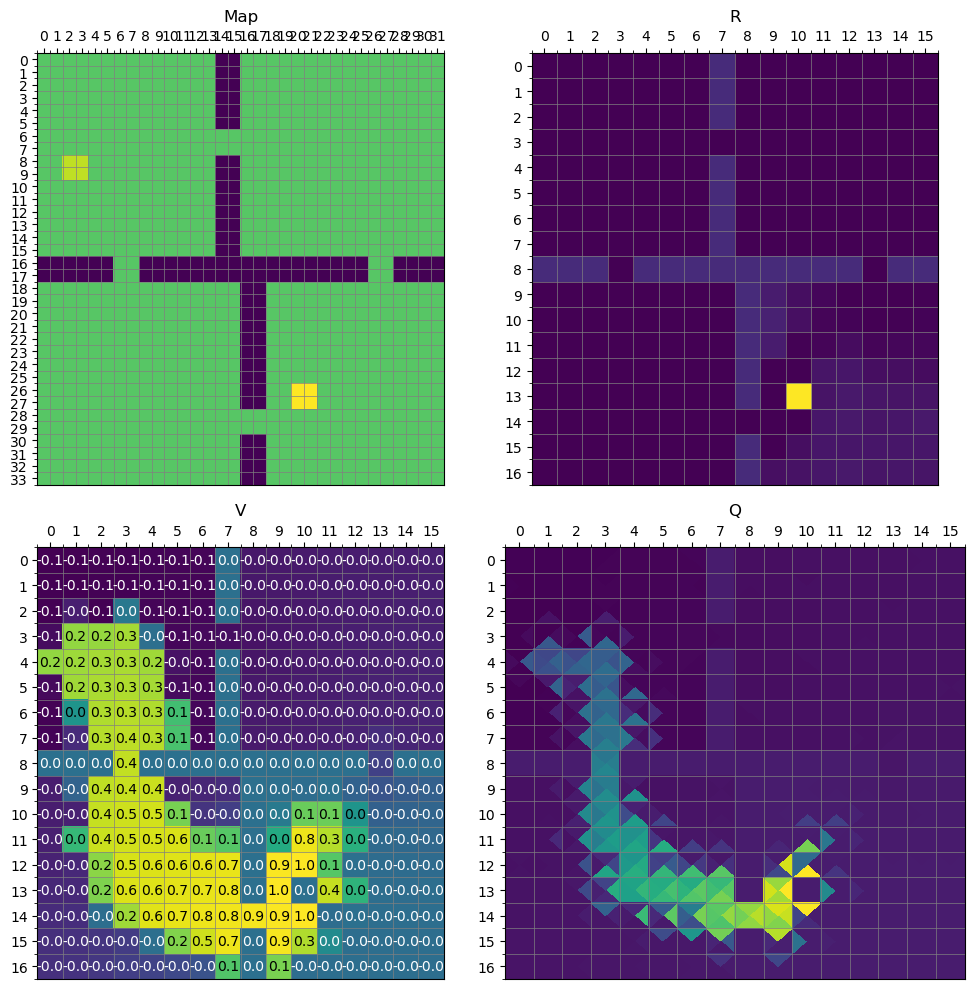

In [133]:
env.reset()

plot_grid_images(
    [env.render(), R_sq, Q_sq.max(axis=-1), Q_sq], 
    ['Map', 'R', 'V', 'Q'],
    cols_per_row=2,
    with_value_text_flags=[False, False, True, False]
)

In [57]:
from IPython.display import Video
from IPython import display

def show_video(path):
    display(Video(path, embed=True))